## Cancer Image Classification

In [ ]:
!pip install kagglehub

In [2]:
# Import the necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, BatchNormalization, Input
from tensorflow.keras.layers import Activation, AveragePooling2D, Concatenate, Add, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks  import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import os
import warnings
warnings.filterwarnings('ignore')

2025-02-11 15:36:42.717435: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-11 15:36:42.865685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739288202.926112    1795 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739288202.944225    1795 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-11 15:36:43.101027: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### 2. Load the Dataset

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohamedhanyyy/chest-ctscan-images")

print("Path to dataset files:", path)

Path to dataset files: /teamspace/studios/this_studio/.cache/kagglehub/datasets/mohamedhanyyy/chest-ctscan-images/versions/1


In [4]:
# dataset_path = "/teamspace/studios/this_studio/.cache/kagglehub/datasets/mohamedhanyyy/chest-ctscan-images/versions/1" 

# # Check downloaded dataset structure
# for root, dirs, files in os.walk(dataset_path):
#     print(f"Directory: {root}")
#     print(f"Subdirectories: {dirs}")
#     print(f"Files: {files}")
#     print("-" * 50)

### 3. Split the dataset into train, test and validation set

In [5]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define dataset paths
dataset_path = "/teamspace/studios/this_studio/.cache/kagglehub/datasets/mohamedhanyyy/chest-ctscan-images/versions/1/Data"

# Load datasets
img_size = (224, 224)
batch_size = 32

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + "/train", 
    image_size=img_size, 
    batch_size=batch_size, 
    label_mode='categorical')

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + "/valid", 
    image_size=img_size, 
    batch_size=batch_size, 
    label_mode='categorical')

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + "/test", 
    image_size=img_size, 
    batch_size=batch_size, 
    label_mode='categorical')

Found 613 files belonging to 4 classes.


Found 72 files belonging to 4 classes.
Found 315 files belonging to 4 classes.


W0000 00:00:1739288210.651657    1795 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### 4. Standardize the Image Data

In [6]:
from tensorflow.keras import layers, models

# Normalize images
normalization_layer = layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

### 5. Image Data Augmentation 

In [ ]:
# Image Augmentation

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

Purpose: To increase our data sample and also improve the model robustness

### 6. Defining the Model Architecture

In [7]:
# number of classes
num_classes = 4

# Define CNN model
model = models.Sequential([
    
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(128, (3, 3), activation='relu'),

    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Conv2D(256, (3, 3), activation='relu'),

    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 107, 107, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 51, 51, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 49, 49, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    18,874,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,991,492 (76.26 MB)

 Trainable params: 19,991,492 (76.26 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compile model
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

### 7. Training the Model

In [9]:
# Train model
epochs = 30

history = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=epochs
)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.2579 - loss: 1.6313 - val_accuracy: 0.1806 - val_loss: 1.4225
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.2954 - loss: 1.3367 - val_accuracy: 0.4583 - val_loss: 1.2075
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.4278 - loss: 1.2362 - val_accuracy: 0.5000 - val_loss: 1.1536
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.4947 - loss: 1.2066 - val_accuracy: 0.5000 - val_loss: 1.0096
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.4816 - loss: 1.0598 - val_accuracy: 0.5833 - val_loss: 0.9810
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.4916 - loss: 1.0446 - val_accuracy: 0.5556 - val_loss: 0.8408
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5794 - loss: 0.9235 - val_accuracy: 0.5972 - val_loss: 0.8478
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6049 - loss: 0.9545 - val_accuracy: 0.6528 - val_loss:

### 8. Evaluating the Model on the Test data

In [10]:
# Evaluate model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 614ms/step - accuracy: 0.5418 - loss: 2.0612
Test Accuracy: 0.5365


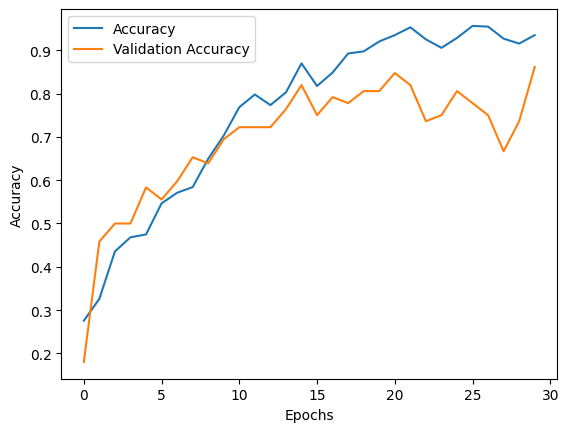

In [11]:
import matplotlib.pyplot as plt


# Plot training history
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Define the class names
class_names = np.array(['cat', 'dog'])

# Get one batch of test images and labels
image_batch, label_batch = next(iter(validation_batches))
print("Image batch shape:", image_batch.shape) 

# Get the predicted classes for the test images
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

# Determine the number of images in the batch
num_images = image_batch.shape[0]
print("Number of images in batch:", num_images)

plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.3)

# Display as many images as are available (or limit to 30)
for n in range(min(30, num_images)):
    ax = plt.subplot(6, 5, n + 1)
    ax.imshow(image_batch[n])
    # Adjust this if your labels are one-hot encoded:
    color = "green" if predicted_id[n] == label_batch[n] else "red"
    ax.set_title(predicted_label_batch[n].title(), color=color)
    ax.axis('off')

plt.suptitle("Model predictions (green: correct, red: incorrect)")
plt.show()